<a href="https://colab.research.google.com/github/JohnYCLam/MachineLearning/blob/main/PyTorch_Custom_Dataset_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Data

In [1]:
import torch
from torch import nn

In [2]:
#set up device (cpu/ gpu) for computation
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if not image_path.is_dir():
    image_path.mkdir(parents = True, exist_ok = True)

    f = open(data_path/ "pizza_steak_sushi.zip", "wb")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

    zip_ref = zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r")
    zip_ref.extractall(image_path)

In [4]:
#Have a look on the data directory
import os

def directory_tree(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{dirpath:40s} | {len(dirnames)} folders | {len(filenames)} files")
        print(f"{'-'*70}")

directory_tree(image_path)

data/pizza_steak_sushi                   | 2 folders | 0 files
----------------------------------------------------------------------
data/pizza_steak_sushi/test              | 3 folders | 0 files
----------------------------------------------------------------------
data/pizza_steak_sushi/test/pizza        | 0 folders | 25 files
----------------------------------------------------------------------
data/pizza_steak_sushi/test/steak        | 0 folders | 19 files
----------------------------------------------------------------------
data/pizza_steak_sushi/test/sushi        | 0 folders | 31 files
----------------------------------------------------------------------
data/pizza_steak_sushi/train             | 3 folders | 0 files
----------------------------------------------------------------------
data/pizza_steak_sushi/train/pizza       | 0 folders | 78 files
----------------------------------------------------------------------
data/pizza_steak_sushi/train/steak       | 0 folders | 75 

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

Path: data/pizza_steak_sushi/train/steak/560503.jpg
Label: steak
Dimension: 512 x 512


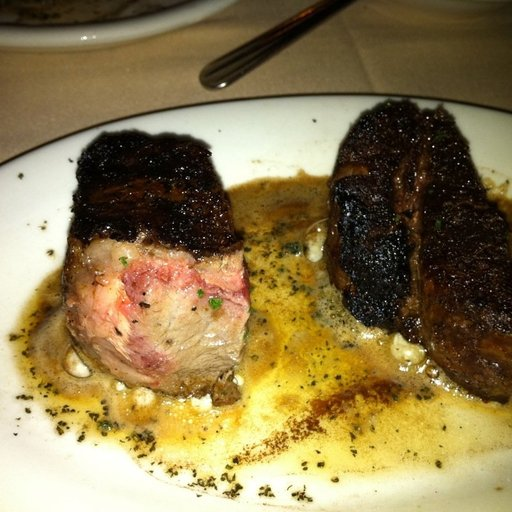

In [6]:
#visualize an image
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Path: {random_image_path}")
print(f"Label: {image_class}")
print(f"Dimension: {img.height} x {img.width}")
img

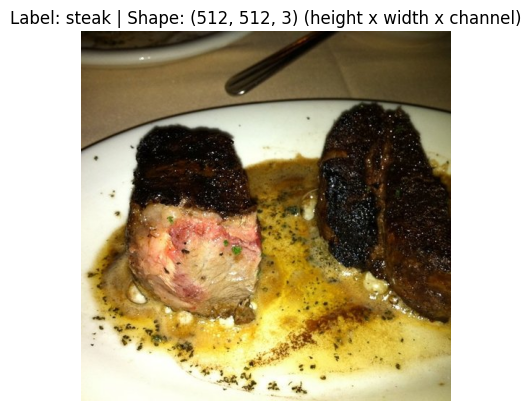

In [7]:
#Alternatively, we can visualize the image with matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt

#need to transform image to np array for visualization
img_array = np.asarray(img)

plt.imshow(img_array)
plt.title(f"Label: {image_class} | Shape: {img_array.shape} (height x width x channel)")
plt.axis(False);

#Custom Dataset

In [ ]:
#Transform the image to tensors and load to dataloader
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (128, 128)),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    #transforms.RandomRotation(30),
    #transforms.RandomCrop((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (128, 128)),
    #transforms.RandomHorizontalFlip(p = 0.3),
    #transforms.RandomVerticalFlip(p = 0.3),
    #transforms.RandomRotation(30),
    #transforms.CenterCrop((224, 224)),
    transforms.ToTensor()
])

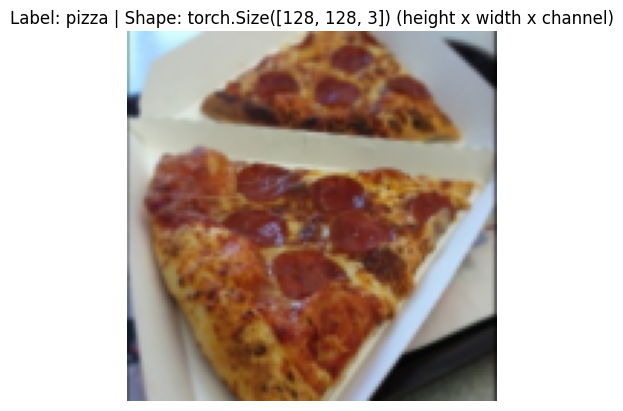

In [ ]:
#Visualize a transformed image
#from PyTorch (C, H, W) to Matplotlib (H, W, C)
transformed_img = train_transform(img).permute(1,2,0)
plt.imshow(transformed_img)
plt.title(f"Label: {image_class} | Shape: {transformed_img.shape} (height x width x channel)")
plt.axis(False);

In [ ]:
train_data = datasets.ImageFolder(root = train_dir, transform = train_transform)
test_data = datasets.ImageFolder(root = test_dir, transform = test_transform)

print(f"Train Data:")
print(train_data)

print(f"Test Data:")
print(test_data)

Train Data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.3)
               RandomVerticalFlip(p=0.3)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
print(f"No. of Train Data: {len(train_data)} | No. of Test Data: {len(test_data)}")
print(f"Classes: {class_names} | Indices: {class_dict}")

No. of Train Data: 225 | No. of Test Data: 75
Classes: ['pizza', 'steak', 'sushi'] | Indices: {'pizza': 0, 'steak': 1, 'sushi': 2}


torch.Size([3, 128, 128]) torch.float32
0


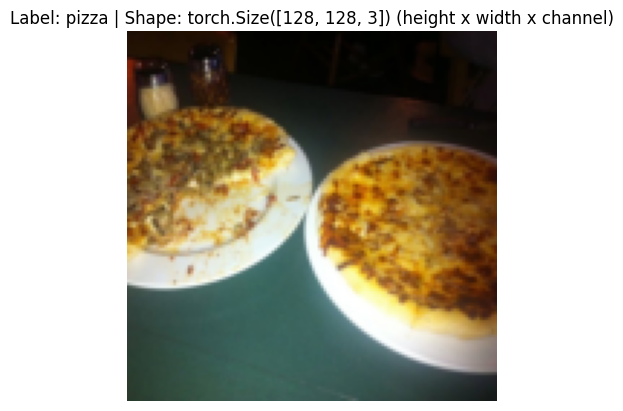

In [ ]:
#train_data[i] = (i-th img_tensor, i-th img_label)
print(train_data[0][0].shape, train_data[0][0].dtype)
print(train_data[0][1])

plt.imshow(train_data[0][0].permute(1,2,0))
plt.title(f"Label: {class_names[train_data[0][1]]} | Shape: {train_data[0][0].permute(1,2,0).shape} (height x width x channel)")
plt.axis(False);

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers)
test_dataloader = DataLoader(test_data, batch_size, shuffle = False, num_workers = num_workers)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_shape, hidden_unit_1, hidden_unit_2, hidden_unit_3, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_unit_1, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_unit_1, out_channels = hidden_unit_1, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_unit_1, out_channels = hidden_unit_2, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_unit_2, out_channels = hidden_unit_2, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_unit_2, out_channels = hidden_unit_3, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_unit_3, out_channels = hidden_unit_3, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_unit_3 * 16 * 16, out_features = output_shape )
        )

    def forward(self, x):
        x = self.block_1(x)
        #print(f'block 1 shape: {x.shape}')
        x = self.block_2(x)
        #print(f'block 2 shape: {x.shape}')
        x = self.block_3(x)
        #print(f'block 3 shape: {x.shape}')
        #x = self.block_4(x)
        #print(f'block 4 shape: {x.shape}')
        #x = self.block_5(x)
        #print(f'block 5 shape: {x.shape}')
        x = self.connected(x)
        #print(f'connected block shape: {x.shape}')
        return x

cnn_model = CNNModel(3, 15, 15, 15, len(class_names)).to(device)
cnn_model

CNNModel(
  (block_1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (connected): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3840, out

In [ ]:
#try the model with 1 image
img_batch, label_batch = next(iter(train_dataloader))

img_sample = img_batch[0].unsqueeze(dim = 0)

label_sample = label_batch[0]

cnn_model.eval()
pred = cnn_model(img_sample.to(device))
label_sample, torch.argmax(torch.softmax(pred, dim = 1), dim = 1)

(tensor(0), tensor([0], device='cuda:0'))

In [19]:
!pip install torchinfo

In [ ]:
from  torchinfo import summary
summary(cnn_model, input_size = [1, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 3]                    --
├─Sequential: 1-1                        [1, 15, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 15, 128, 128]         420
│    └─ReLU: 2-2                         [1, 15, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 15, 128, 128]         2,040
│    └─ReLU: 2-4                         [1, 15, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 15, 64, 64]           --
├─Sequential: 1-2                        [1, 15, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 15, 64, 64]           2,040
│    └─ReLU: 2-7                         [1, 15, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 15, 64, 64]           2,040
│    └─ReLU: 2-9                         [1, 15, 64, 64]           --
│    └─MaxPool2d: 2-10                   [1, 15, 32, 32]           --
├─Seq

In [ ]:
def train_step(model, dataloader, loss_fcn, optimizer, device):

    model.train()

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)

        loss = loss_fcn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += ((y_pred_class == y)).sum().item()/len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


In [ ]:
def test_step(model, dataloader, loss_fcn, device):

    test_loss = 0
    test_acc = 0

    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            y_pred = model(X)

            loss = loss_fcn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
            test_acc += ((y_pred_class == y)).sum().item()/len(y_pred)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
def training(model, train_dataloader, test_dataloader, optimizer, device, loss_fcn = nn.CrossEntropyLoss(), epochs = 100):
    results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in tqdm(range(epochs)):
        train_start = timer()
        train_loss, train_acc = train_step(model, train_dataloader, loss_fcn, optimizer, device)
        train_end = timer()
        test_start = timer()
        test_loss, test_acc = test_step(model, test_dataloader, loss_fcn, device)
        test_end = timer()

        results['train_loss'] = train_loss
        results['train_acc'] = train_acc
        results['test_loss'] = test_loss
        results['test_acc'] = test_acc

        if epoch == 0 or (epoch+1)%10 == 0:
            print(f"Epoch {epoch + 1}| train loss: {train_loss:.3f} | train acc: {train_acc:.3f} | train time: {train_end - train_start:.3f} | test loss: {test_loss:.3f} | test acc: {test_acc:.3f} | test time: {test_end - test_start:.3f}")

    return results

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

optimizer = torch.optim.Adam(params = cnn_model.parameters(), lr = 0.001)
loss_fcn = nn.CrossEntropyLoss()

from timeit import default_timer as timer
start_time = timer()
results = training(cnn_model, train_dataloader, test_dataloader, optimizer, device, loss_fcn)
end_time = timer()
print(f"Total Time: {end_time - start_time:.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1| train loss: 1.106 | train acc: 0.250 | train time: 1.226 | test loss: 1.101 | test acc: 0.260 | test time: 0.543
Epoch 10| train loss: 0.932 | train acc: 0.430 | train time: 0.860 | test loss: 0.930 | test acc: 0.532 | test time: 0.360
Epoch 20| train loss: 0.782 | train acc: 0.691 | train time: 0.920 | test loss: 1.031 | test acc: 0.442 | test time: 0.626
Epoch 30| train loss: 0.770 | train acc: 0.676 | train time: 1.051 | test loss: 0.930 | test acc: 0.513 | test time: 0.624
Epoch 40| train loss: 0.690 | train acc: 0.738 | train time: 1.337 | test loss: 1.163 | test acc: 0.393 | test time: 0.530
Epoch 50| train loss: 0.545 | train acc: 0.789 | train time: 1.440 | test loss: 1.141 | test acc: 0.463 | test time: 0.505
Epoch 60| train loss: 0.387 | train acc: 0.852 | train time: 1.465 | test loss: 1.477 | test acc: 0.525 | test time: 0.529
Epoch 70| train loss: 0.463 | train acc: 0.871 | train time: 1.402 | test loss: 1.266 | test acc: 0.485 | test time: 0.424
Epoch 80| train l

#Transfer Learning

In [9]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

auto_transforms = weights.transforms()
print(auto_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [12]:
from torchvision import datasets, transforms

train_data = datasets.ImageFolder(root = train_dir, transform = auto_transforms)
test_data = datasets.ImageFolder(root = test_dir, transform = auto_transforms)

In [13]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers)
test_dataloader = DataLoader(test_data, batch_size, shuffle = False, num_workers = num_workers)

In [16]:
class_names = train_data.classes

In [17]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 159MB/s]


In [22]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names))
    ).to(device)

In [23]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 